In [39]:
from numba import cuda
cuda.select_device(0)
cuda.close()

In [1]:
import os
import h5py
import numpy as np
import time

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count
from IPython.display import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from cryoem.conversions import d_q, euler2quaternion
from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv

In [2]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [3]:
# location of *.h5 files
#data_dir = f"{ROOT_DIR}/data"
data_dir = "/mnt/scratch/students/"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,1.0,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
projections = data['Projections']
projections.shape

(5000, 116, 116)

In [5]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

In [10]:
from cryoem.plots import plot_projections, plot_projection


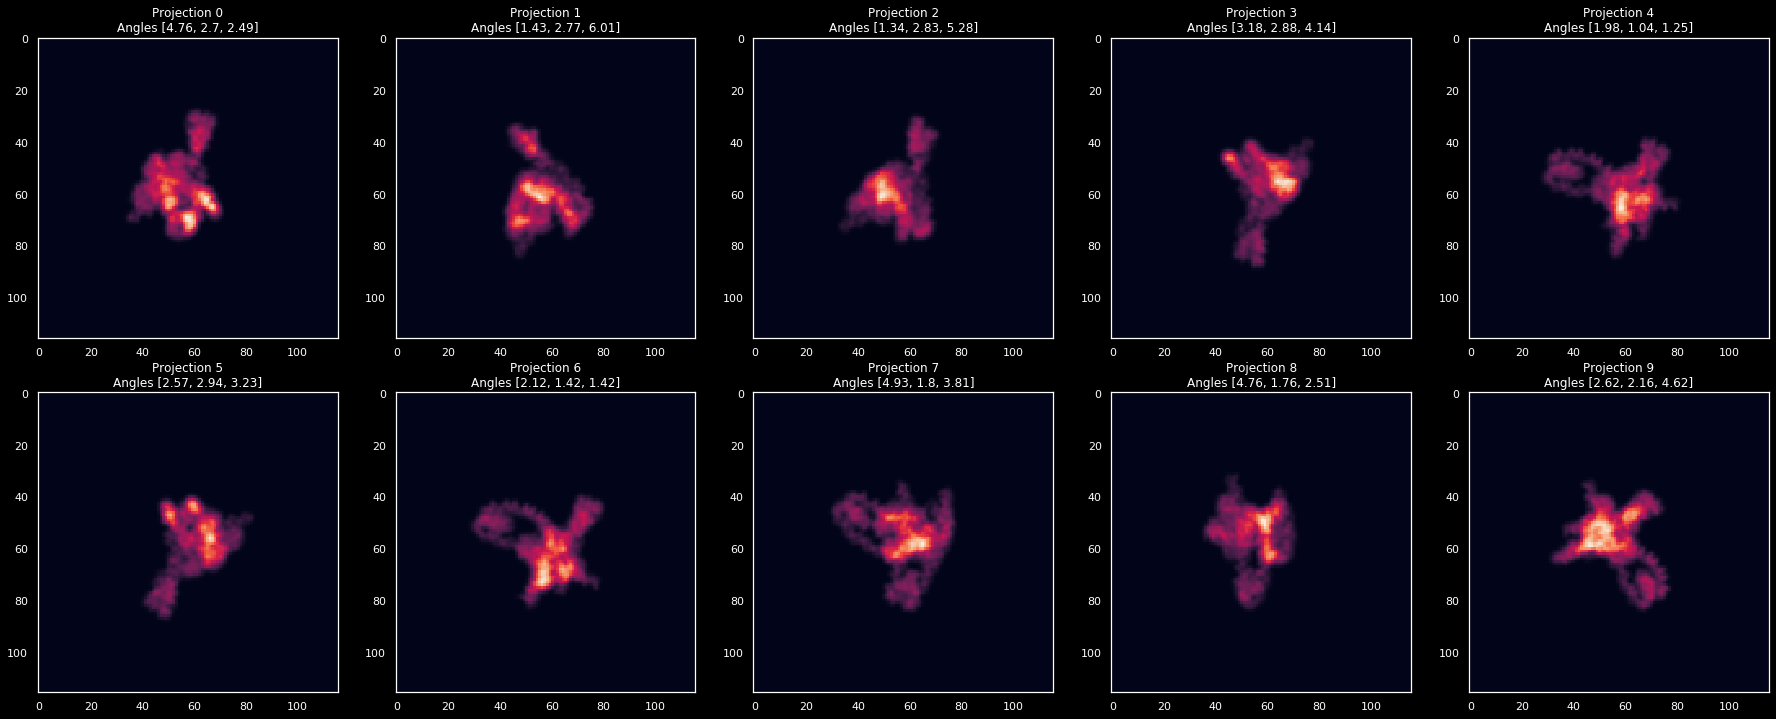

In [12]:
nrows, ncols = 2, 5
start_row, start_col = 0, 0

images = []
titles = []

cr = [(i, j) for i in range(nrows) for j in range(ncols)]

for i, j in cr:
    datapoint = (start_row + i)*(start_col + ncols) + j    

    image = data["Projections"][datapoint]
    #image = image + gaussian_noise(shape=image.shape, mean=0, var=0)

    angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
    title = f'Projection {datapoint}\nAngles {angles}'
    
    images.append(image)
    titles.append(title)
        
plot_projections(images, titles, nrows=nrows, ncols=ncols)

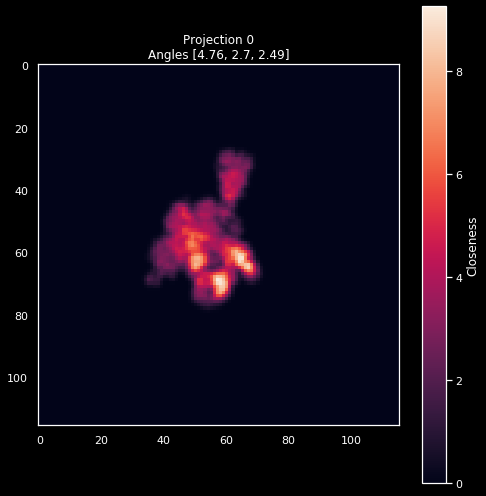

In [61]:
datapoint = 0
image = data["Projections"][datapoint]
angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
title = f'Projection {datapoint}\nAngles {angles}'

plot_projection(image, title)

In [62]:
# ## GLOBAL CENTERING
# # calculate global mean
# mean = pixels.mean()
# print('Mean: %.3f' % mean)
# print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# # global centering of pixels
# pixels = pixels - mean
# # confirm it had the desired effect
# mean = pixels.mean()
# print('Mean: %.3f' % mean)
# print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

In [70]:
pixels = data["Projections"][0]
print(pixels.shape)

print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

pixels = pixels.astype('float32')

print("***")
## GLOBAL STANDARDIZATION
# calculate global mean and standard deviation
mean, std = pixels.mean(), pixels.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
# global standardization of pixels
pixels = (pixels - mean) / std
# confirm it had the desired effect
mean, std = pixels.mean(), pixels.std()
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))

(116, 116)
Data Type: float64
Min: 0.000, Max: 9.263
***
Mean: 0.262, Standard Deviation: 1.030
Min: -0.254, Max: 8.742
Mean: -0.000, Standard Deviation: 1.000


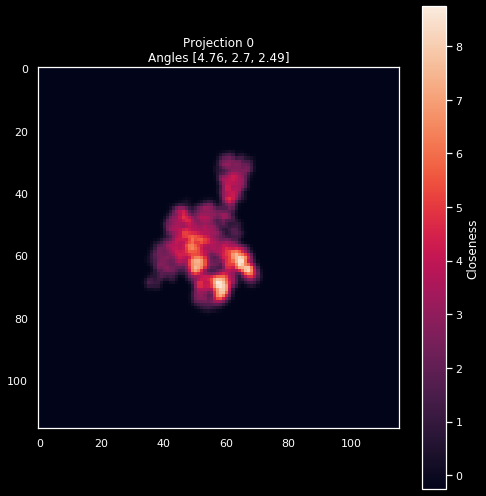

In [71]:
datapoint = 0
image = pixels
angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
title = f'Projection {datapoint}\nAngles {angles}'

plot_projection(image, title)

In [72]:
pixels = data["Projections"][0]
print(pixels.shape)

print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

pixels = pixels.astype('float32')

print("***")
## POSITIVE GLOBAL STANDARDIZATION
# calculate global mean and standard deviation
mean, std = pixels.mean(), pixels.std()
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
# global standardization of pixels
pixels = (pixels - mean) / std
# clip pixel values to [-1,1]
pixels = np.clip(pixels, -1.0, 1.0)
# shift from [-1,1] to [0,1] with 0.5 mean
pixels = (pixels + 1.0) / 2.0
# confirm it had the desired effect
mean, std = pixels.mean(), pixels.std()
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))


(116, 116)
Data Type: float64
Min: 0.000, Max: 9.263
***
Mean: 0.262, Standard Deviation: 1.030
Min: 0.373, Max: 1.000
Mean: 0.421, Standard Deviation: 0.162


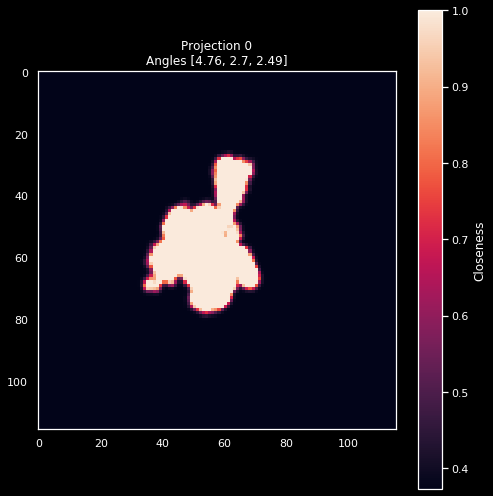

In [74]:
datapoint = 0
image = pixels
angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
title = f'Projection {datapoint}\nAngles {angles}'

plot_projection(image, title)

In [73]:
# ## NORMALIZATION
# # normalize to the range 0-1
# pixels /= 255.0
# # confirm the normalization
# print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))

In [59]:
pixels = pixels*std +mean

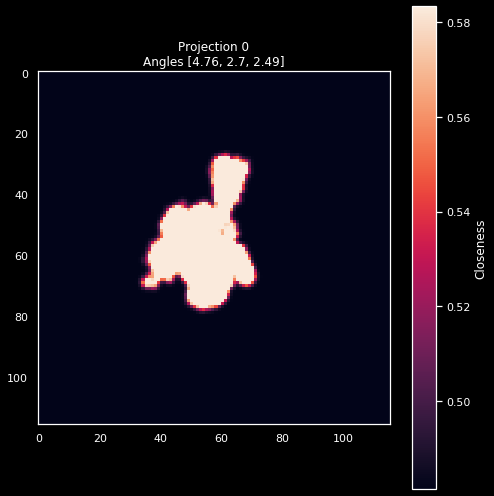

In [60]:
datapoint = 0
image = pixels
angles = [ float(f"{x:.2f}") for x in data["Angles"][datapoint] ]
title = f'Projection {datapoint}\nAngles {angles}'

plot_projection(image, title)